In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [15]:
d_tr = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/train.csv', index_col='Id')
d_te = pd.read_csv('/Users/antirrabia/Documents/01-GitHub/DataMining-_-/CSV/HousePrices/test.csv', index_col='Id')

In [16]:
y = d_tr.SalePrice.copy()
d_tr = d_tr.drop(columns=['SalePrice', 'Utilities']).copy()

d_te = d_te.drop(columns= 'Utilities').copy()

# d_tr = (1460, 80) , d_te = (1459, 79) = 2919
all_d = pd.concat([d_tr, d_te])#.reset_index()
# full.set_index('Id', inplace=True)

# no need to have this column all value are the same 
# 'AllPub' 2 nan and 1 NoSewa
# all_d = all_d.drop(columns='Utilities')

### distribution of columns

In [17]:
# columns alredy number
num_col = [
            'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
            'LowQualFinSF', 'GrLivArea', 'Fireplaces', 'GarageCars',
            'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
            '3SsnPorch', 'ScreenPorch', 'PoolArea'
           ]

# columns that are categorical and alredy encoded
cat_col = ['MSSubClass', 'OverallQual', 'OverallCond']

# columns that are categorical but need to be encoded
cat_col_ = [
            'MSZoning', 'Street', 'Alley', 'LotShape',
            'LandContour', 'LotConfig', 'LandSlope',
           'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
           'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
           'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
           'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
           'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
           'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
           'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
           'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
           'MiscFeature', 'SaleType', 'SaleCondition'
           ]

# columns that need to be explored
# on the dataset info appers 'Bedroom' 
# but in the dataset is 'BedroomAbvGr'
# 'Bedroom' -> 'BedroomAbvGr'
# 'Kitchen' -> 'KitchenAbvGr'
#
others_ = [ 
           'LotFrontage', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 
           'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
           'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'MiscVal',
           'MoSold', 'YrSold'
          ]

total_col = num_col + cat_col + cat_col_ + others_

print('total columns = ', len(total_col))
print('num_col  = ', len(num_col))
print('cat_col  = ', len(cat_col))
print('cat_col_ = ', len(cat_col_))
print('other_   = ', len(others_))

print('\ntotal d_tr = ', len(d_tr.columns))

total columns =  78
num_col  =  19
cat_col  =  3
cat_col_ =  42
other_   =  14

total d_tr =  78


### cheking if we have all columns

In [5]:
set(d_tr.columns) - set(total_col)

set()

In [10]:
set(d_tr.columns).symmetric_difference(set(total_col))

set()

### imputting nan values

In [6]:
# 34 columns with nan

def fillWithNone(df):
    ''' nan in 'PoolQC' means 'no pool' 
        nan in 'MiscFeature' means 'no misc feature'
        nan in 'Alley' means 'no alley acces'
        nan in 'Fence' means 'no fence'
        nan in 'FireplaceQu' means 'no Fireplace'
        nan in 'GarageType', 'GarageFinish', 'GarageQual',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'
        'BsmtFinType1', 'MasVnrType', 'MSSubClass'
        'GarageCond' replaced with 'None' too
    
    recive a df
    '''
    df = df.copy()
    
    columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
               'FireplaceQu', 'GarageType', 'GarageFinish', 
               'GarageQual', 'GarageCond', 'BsmtQual',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
               'BsmtFinType2', 'MasVnrType'
              ]
    
    for col in columns:
        df[col] = df[col].fillna('None')
    
    return df


def fillWithZero(df):
    ''' nan 
    
    '''
    df = df.copy()
    
    columns = ['GarageYrBlt', 'GarageArea', 'GarageCars',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
               'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
               'MasVnrArea'
              ]
    
    for col in columns:
        df[col] = df[col].fillna(0)
    
    return df



def fillWithMode(df):
    ''' fill missing values with mode, median
    '''
    df = df.copy()
    
    columns = ['Electrical', 'KitchenQual', 'Exterior1st',
               'Exterior2nd', 'SaleType'
              ]
    
    for col in columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    
    df['LotFrontage'] = (
                     df.groupby('Neighborhood')['LotFrontage']
                     .transform(lambda x: x.fillna(x.median()))
                    )  
    
    # nan means Typical
    df['Functional'] = df['Functional'].fillna('Typ')
    
    return df


def mszoning(df):
    ''' recives a DF this imputation takes place on test data only'''
    
    df = df.copy()
    
    idotrr = ( (df['Neighborhood'] == 'IDOTRR') & (df['MSZoning'].isna()) )
    mitchel = ( (df['Neighborhood'] == 'Mitchel') & (df['MSZoning'].isna()) )
    
    df.loc[ idotrr , 'MSZoning'] = 'RM'
    df.loc[ mitchel, 'MSZoning'] = 'RL'
    
#     # to test this function out of here
#     temp = mszoning(d_te)
#     # lable index acces at [1916, 2217, 2251, 2905
#     temp.loc[[1916, 2217, 2251, 2905], 'MSZoning']
    
    return df
    
none_func = FunctionTransformer(fillWithNone, validate=False) 
zero_func = FunctionTransformer(fillWithZero, validate=False) 
mode_func = FunctionTransformer(fillWithMode, validate=False)
mszo_func = FunctionTransformer(mszoning, validate=False)


In [7]:
imputer = Pipeline([
                    ('withNone', none_func), 
                    ('withZero', zero_func), 
                    ('withMode', mode_func), 
                    ('mszoni', mszo_func)
                   ])

In [8]:
new_d = imputer.fit_transform(all_d)

In [9]:
new_d.head(7)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,...,0,0,None,None,None,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,...,0,0,None,None,None,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,...,0,0,None,None,None,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,...,0,0,None,None,None,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,...,0,0,None,None,None,0,12,2008,WD,Normal
6,50,RL,85.0,14115,Pave,None,IR1,Lvl,Inside,Gtl,...,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal
7,20,RL,75.0,10084,Pave,None,Reg,Lvl,Inside,Gtl,...,0,0,None,None,None,0,8,2007,WD,Normal


In [8]:
new_d.columns[new_d.isna().any()].to_list()

[]

In [17]:
skew_col = abs(new_d.skew(numeric_only=True))
skew_col[skew_col > 0.75].shape

(19,)

In [10]:
skew_col.head(7)

MSSubClass       1.376165
LotFrontage      1.506478
LotArea         12.829025
OverallQual      0.197212
OverallCond      0.570605
YearBuilt        0.600114
YearRemodAdd     0.451252
dtype: float64

In [9]:
#categorical base on kaggle description

# allredy categorical encoded

cat_f_num = {'MSSubClass': str, 'OverallQual': str, 'OverallCond': str, 'BsmtFullBath': str, 
 'BsmtHalfBath': str, 'FullBath': str, 'HalfBath': str, 'BedroomAbvGr': str, 
 'KitchenAbvGr': str, 'TotRmsAbvGrd': str, 'Fireplaces': str, 'MoSold': str, 
 'YrSold': str, 'GarageCars': str
 }

# need to be encoded as categorical
cat_f = { 'MSZoning': str, 'Street': str, 'Alley': str, 'LotShape': str, 
         'LandContour': str, 'LotConfig': str, 'LandSlope': str, 'Neighborhood': str, 
         'Condition1': str, 'Condition2': str, 'BldgType': str, 'HouseStyle': str, 
         'RoofStyle': str, 'RoofMatl': str, 'Exterior1st': str, 'Exterior2nd': str, 
         'MasVnrType': str, 'ExterQual': str, 'ExterCond': str, 'Foundation': str, 
         'BsmtQual': str, 'BsmtCond': str, 'BsmtExposure': str, 'BsmtFinType1': str, 
         'BsmtFinType2': str, 'Heating': str, 'HeatingQC': str, 'CentralAir': str, 
         'Electrical': str, 'KitchenQual': str, 'Functional': str, 'FireplaceQu': str, 
         'GarageType': str, 'GarageFinish': str, 'GarageQual': str, 'GarageCond': str, 
         'PavedDrive': str, 'PoolQC': str, 'Fence': str, 'MiscFeature': str, 
         'SaleType': str, 'SaleCondition': str}

# len(cat_f)


#             '', '', '', '',
#             '', 'Utilities', '', '',
#            '', '', '', '',
#            '', '', '', '',
#            '', '', '', '',
#            '', '', '', '',
#            '', '', '', '',
#            '', '', '', '',
#            '', '', '', '',
#            '', '', '', '',
#            '', '', ''



In [12]:
temp = 'PoolArea'
print('Values   : ', d_tr[temp].unique())
print('uniques  : ', len(d_tr[temp].unique()))
print('variance : ', d_tr[temp].var())#.shape

Values   :  [  0 512 648 576 555 480 519 738]
uniques  :  8
variance :  1614.215993315013


### setting the right type of columns

In [10]:
# seting categorical column data type to categorical
new_d = new_d.astype( dict(cat_f, **cat_f_num) )
# new_d = new_d.astype(cat_f_num)
new_d.shape

(2919, 78)

### selecting numerical features

In [12]:
num_f = new_d.select_dtypes(include='number').columns#.to_list()
len(num_f)

22

### maybe this list no longer needed

In [13]:
# may have outliner 
# in some cases we could compare total area vs lotFrontaje
# to see if ther both are iqual

outliner = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 
            'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 
            'WoodDeckSF', 'OpenPorchSF']

# 'y' has outliner too 

# notes
# the sape of the BsmtFinSF2 plot is rare
# the sape of the LowQualFinSF
# 3SsnPorch, ScreenPorch, PoolArea

/var/folders/_3/5c6_d37x1bb_959htt9q2h880000gn/T/ipykernel_2672/1426914145.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 3, figsize=(15,3))


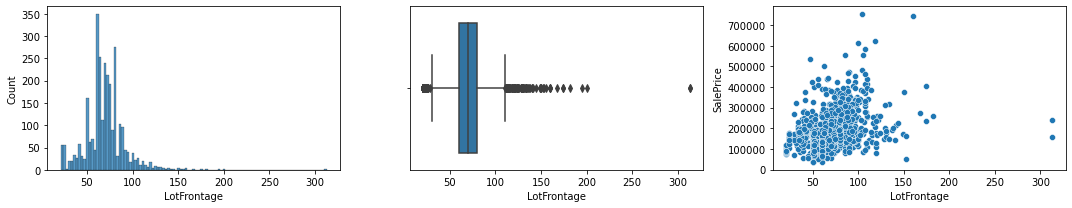

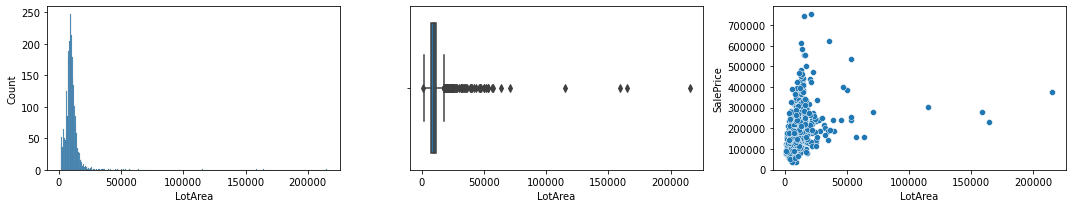

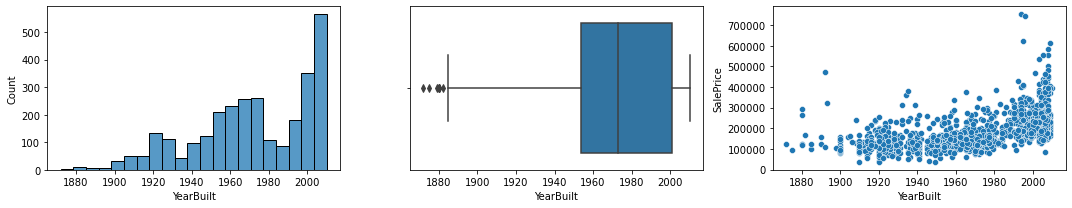

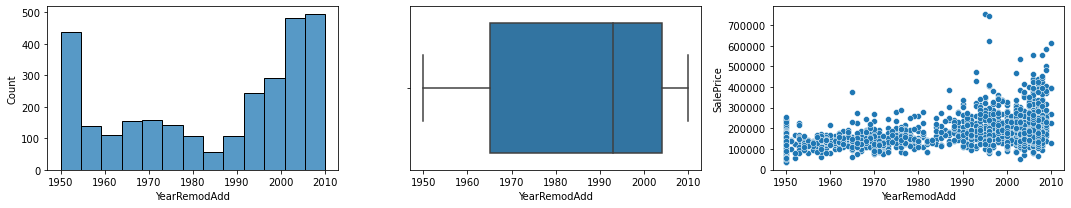

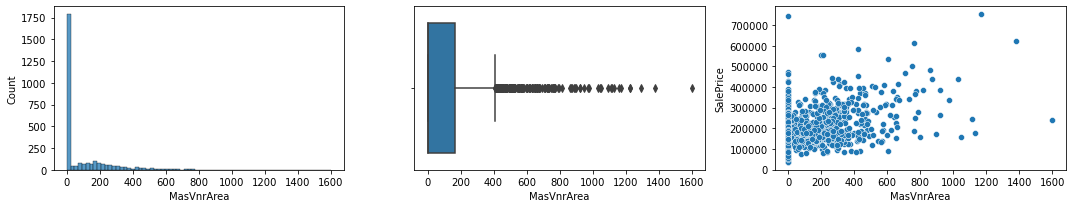

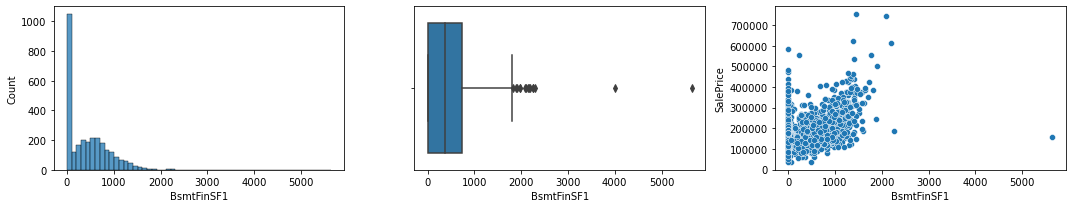

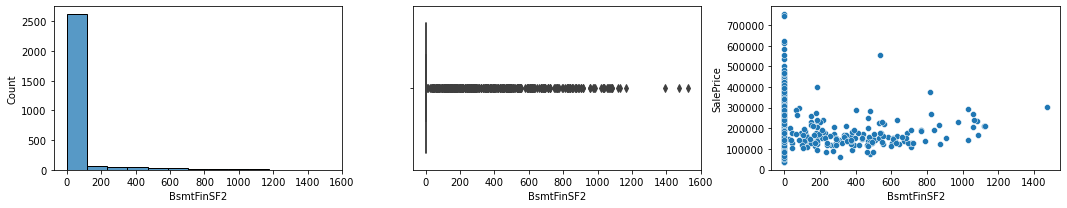

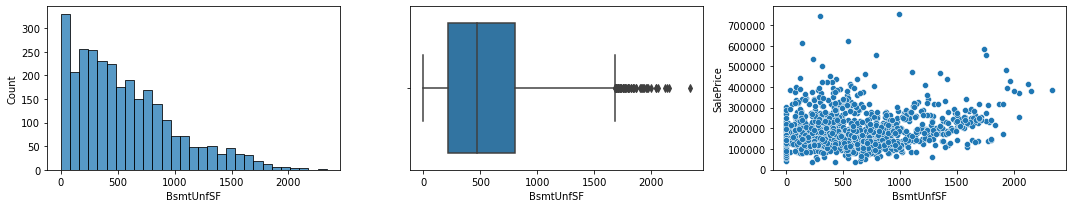

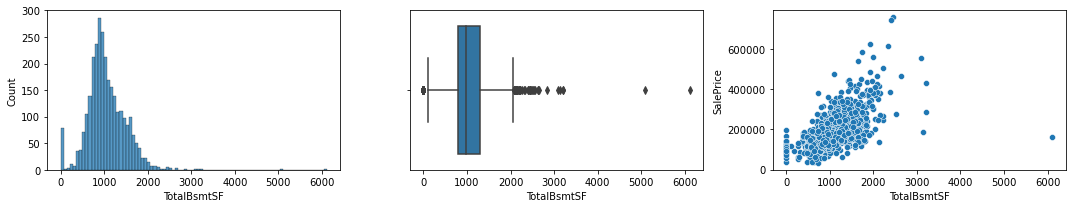

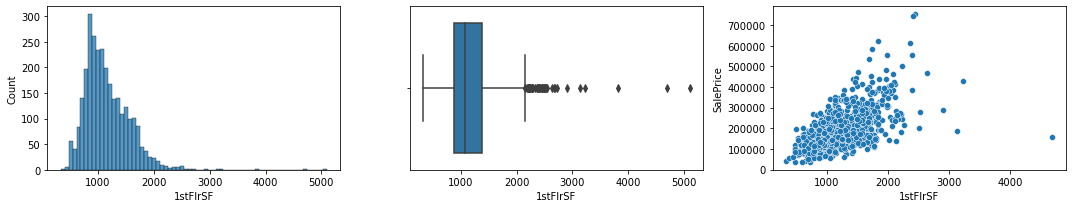

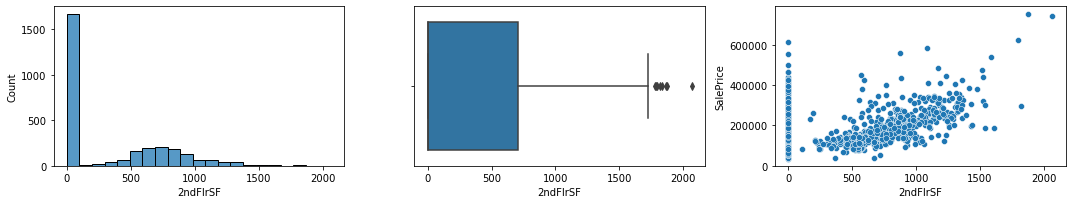

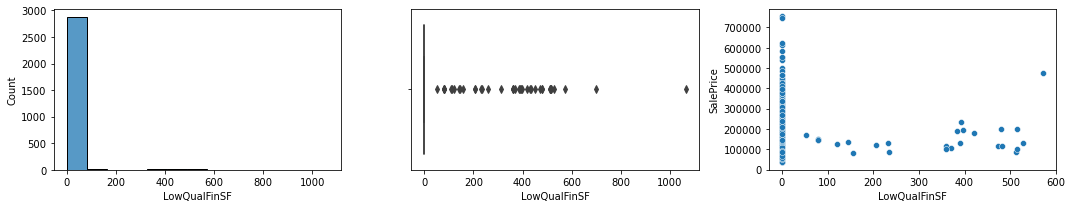

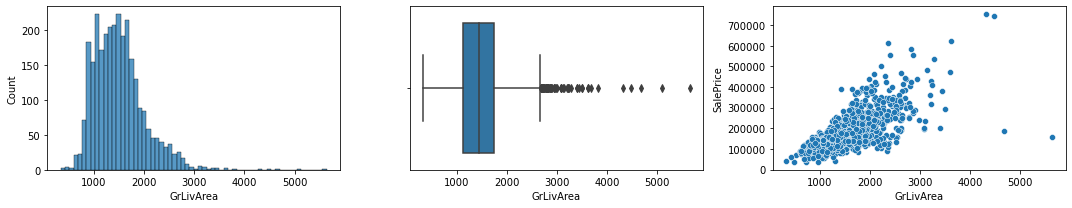

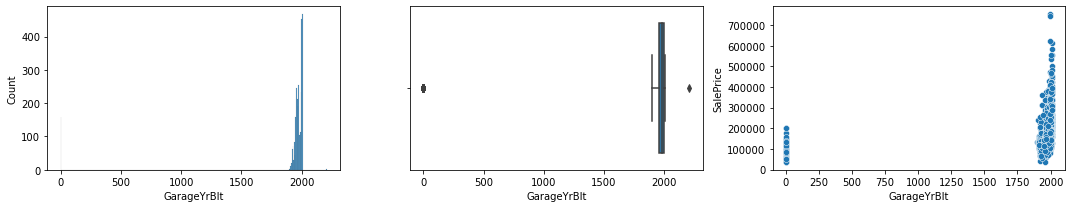

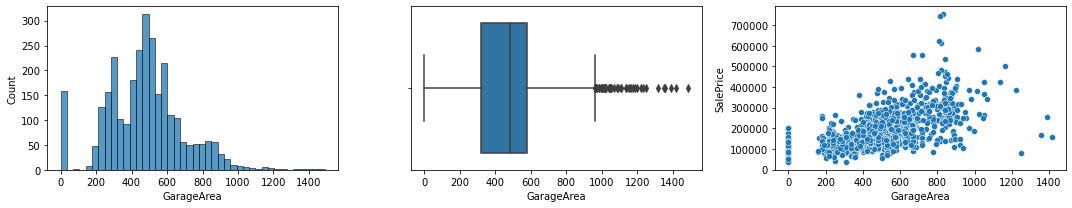

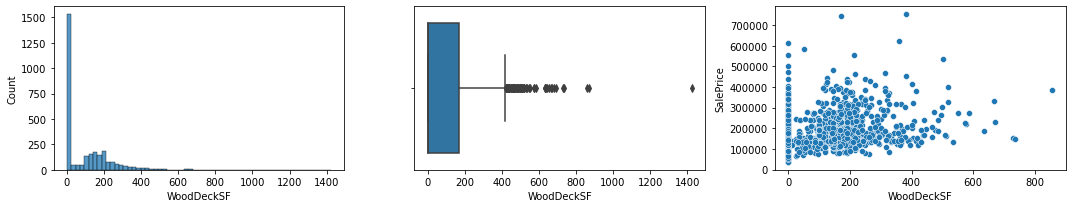

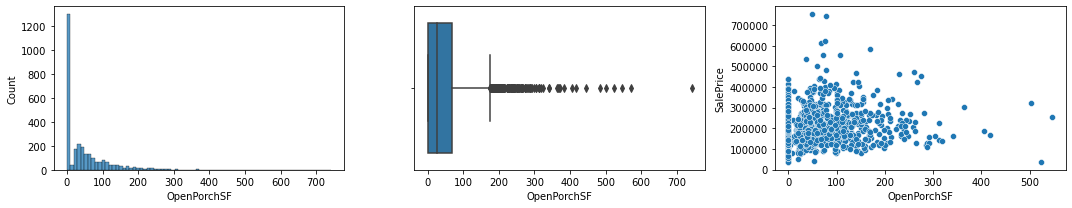

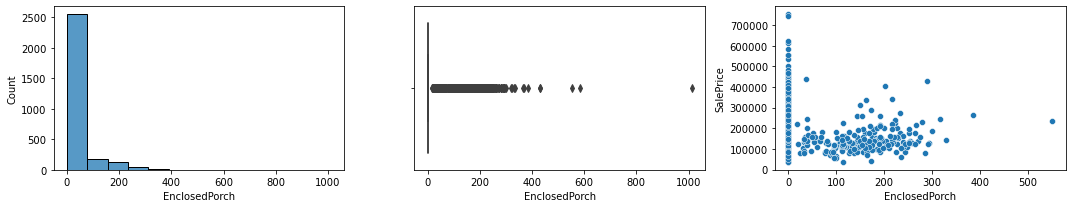

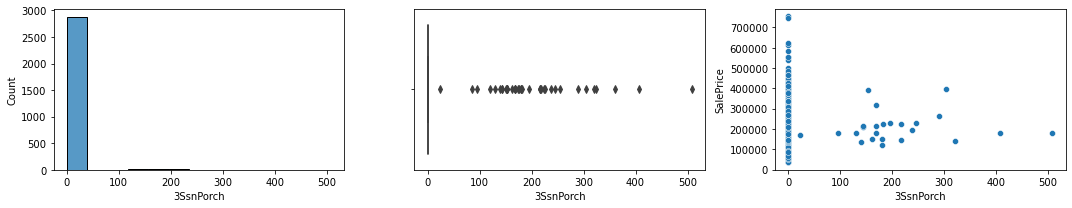

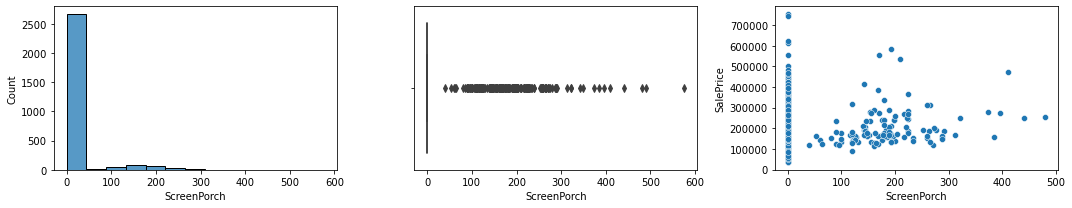

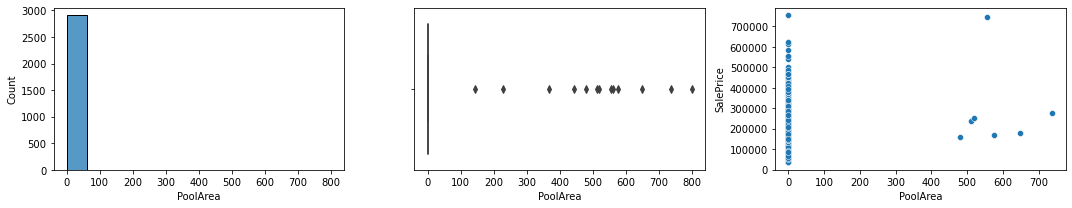

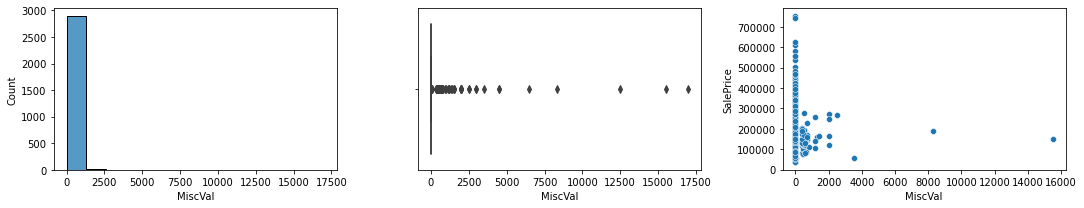

In [14]:
# sns.scatterplot(x=new_d.GrLivArea, y=y);

# num_input = new_d.select_dtypes(include='number').columns.to_list()

for col in num_f:
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    sns.histplot(data=new_d, x=col, ax=ax[0])
    sns.boxplot(data=new_d, x=col, ax=ax[1]);
    sns.scatterplot(data=new_d, x=col, y=y, ax=ax[2]);
    plt.tight_layout() #to fix overlap
    
# plt.close('all')

In [15]:
plt.close('all')

### Getting back Train and Test set with no nan

In [14]:
d_tr = new_d[:1460]
d_te = new_d[1460:]

In [15]:
d_tr.isna().sum().sum()

0

### removing outliers

In [16]:
lof = LocalOutlierFactor()
y_hat = lof.fit_predict(d_tr[num_f])
mask = y_hat != -1

print('before removing outliers X: ', d_tr.shape)
print('before removing outliers y: ', y.shape)

d_tr, y = d_tr[mask], y[mask]

print('\nafter removing outliers X: ', d_tr.shape)
print('after removing outliers y: ', y.shape)



before removing outliers X:  (1460, 78)
before removing outliers y:  (1460,)
after removing outliers:  (1394, 78)
after removing outliers y:  (1394,)


/var/folders/_3/5c6_d37x1bb_959htt9q2h880000gn/T/ipykernel_2672/2065521672.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 3, figsize=(15,3))


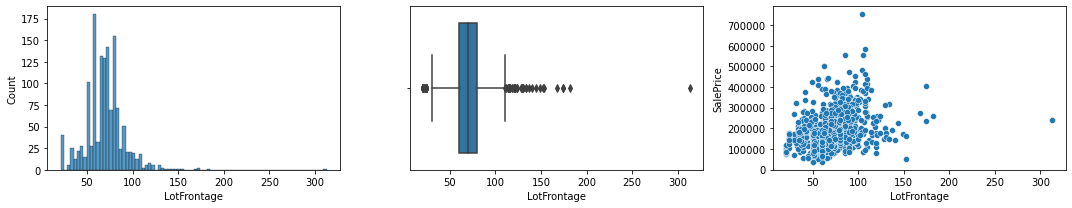

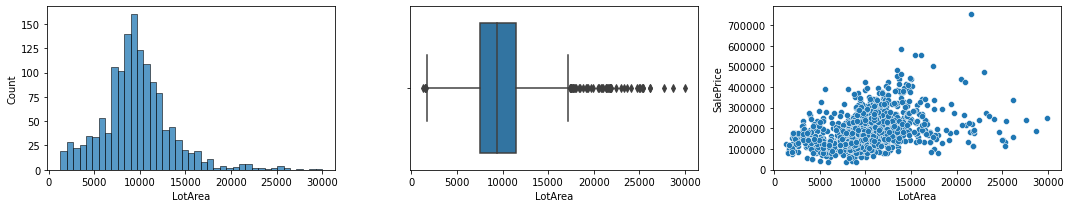

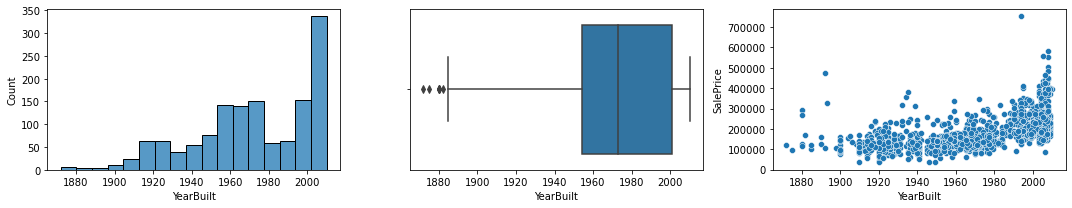

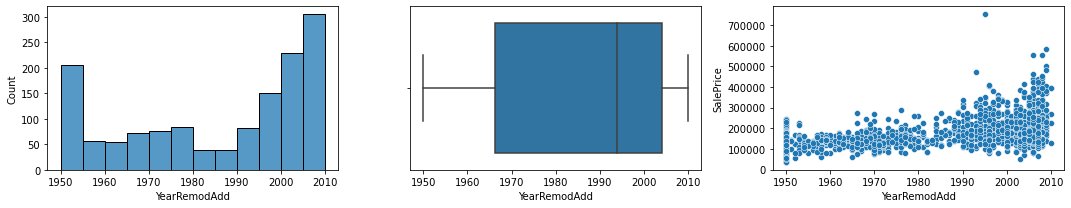

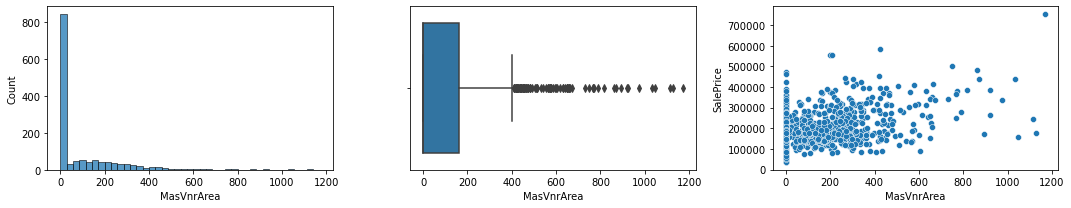

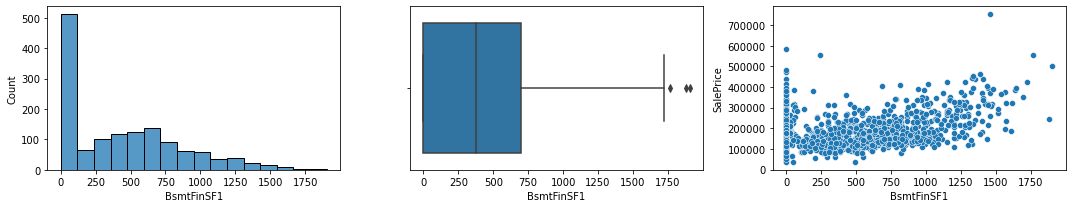

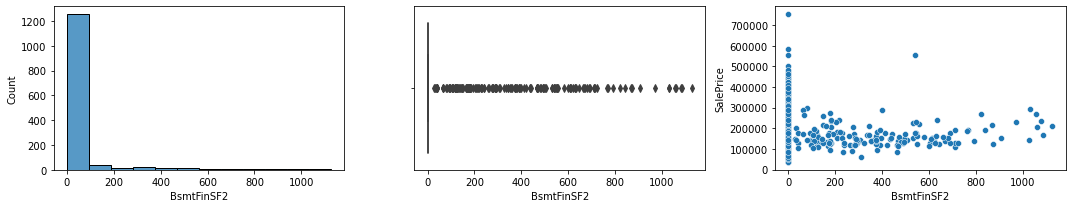

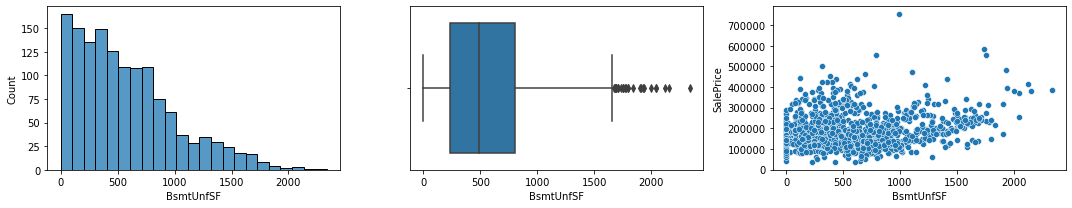

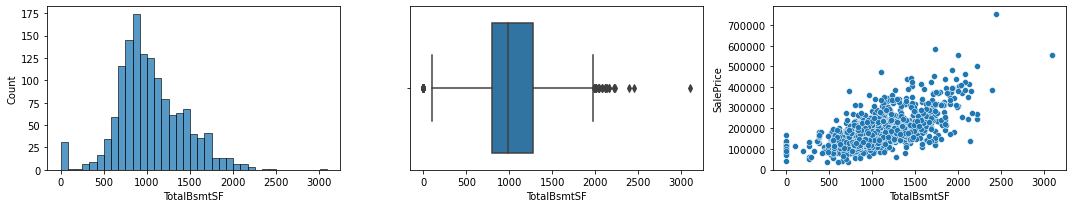

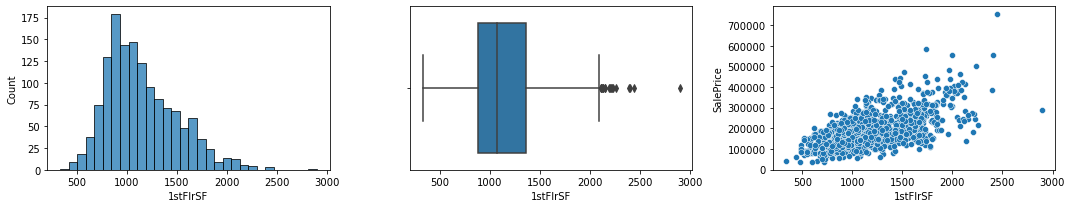

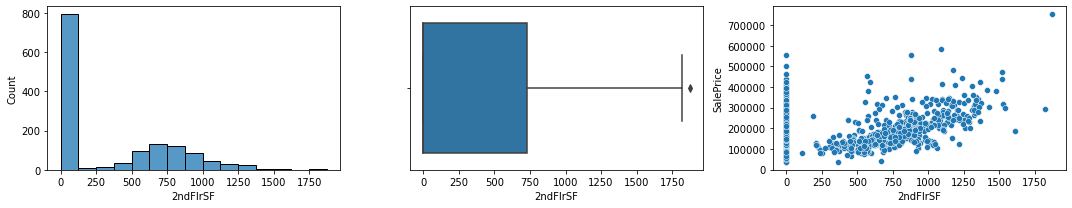

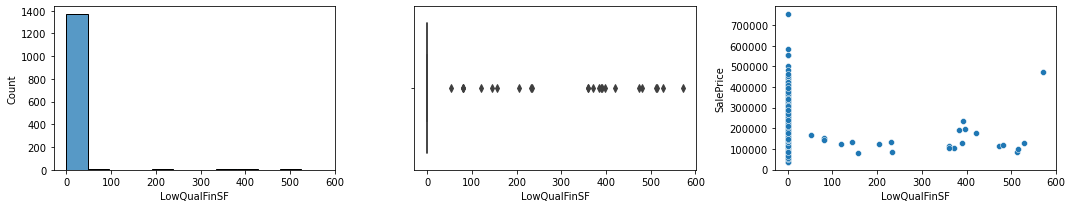

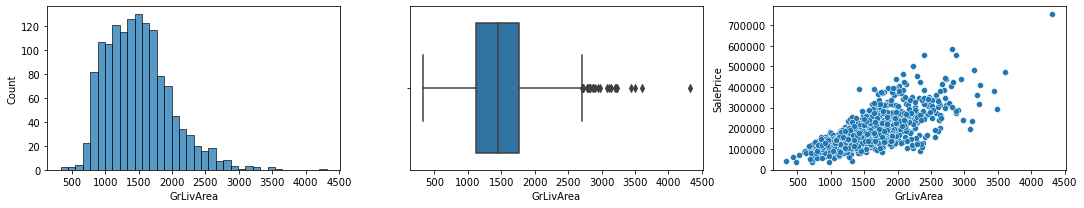

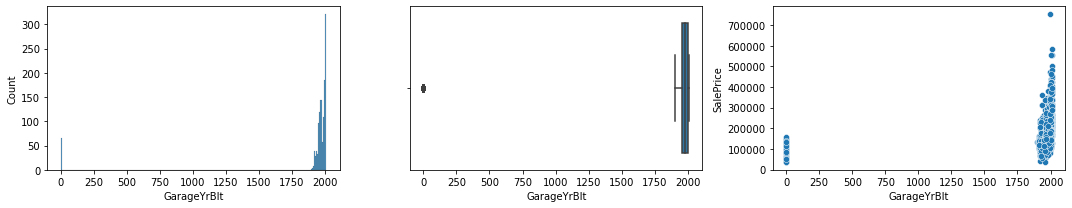

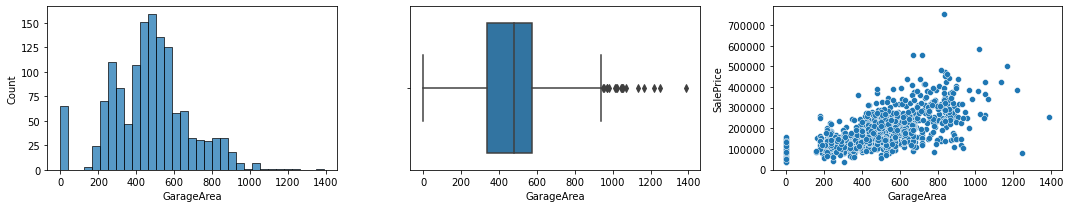

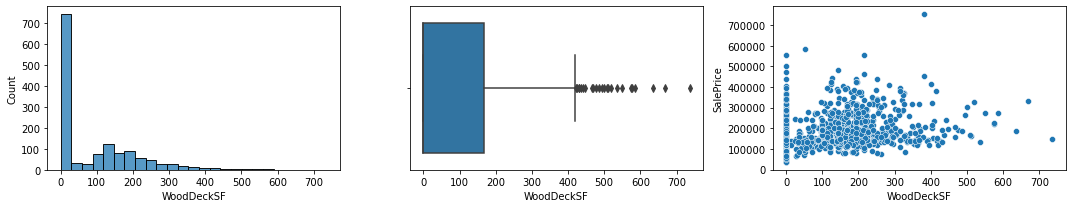

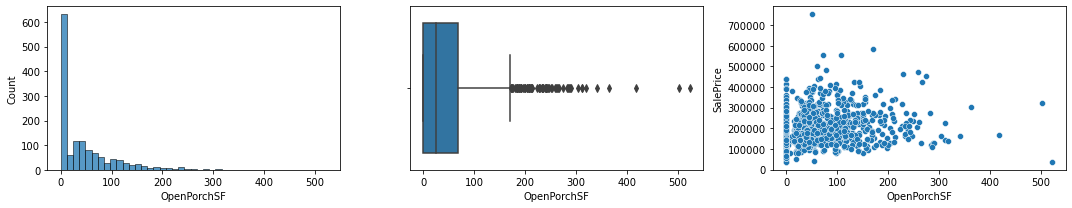

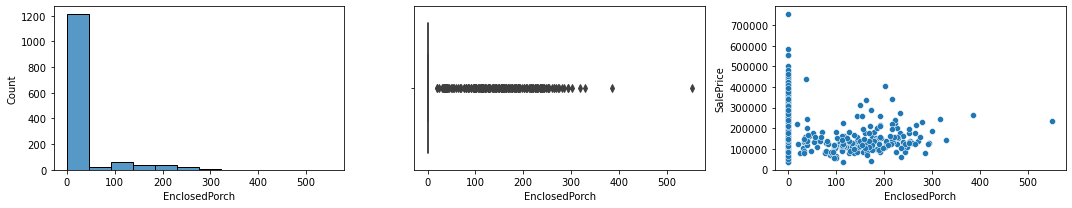

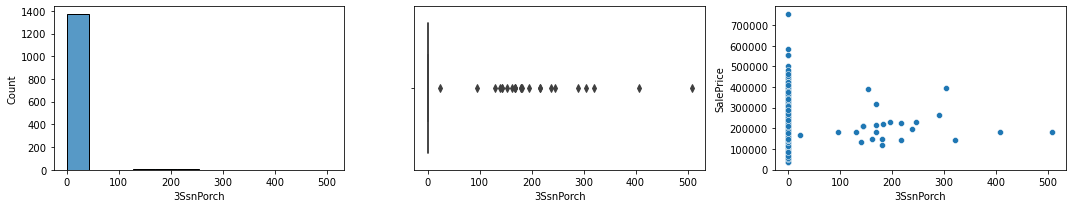

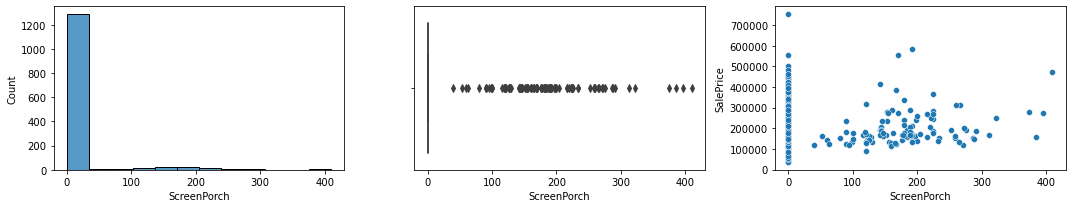

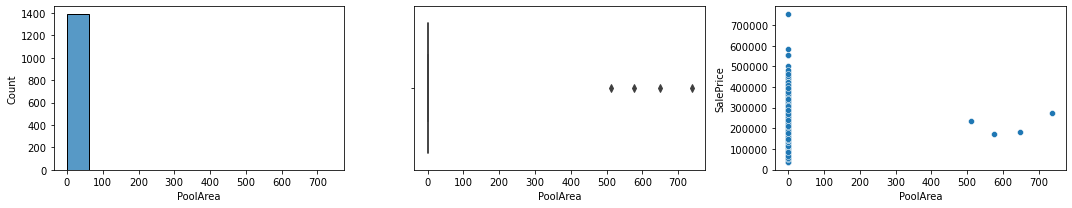

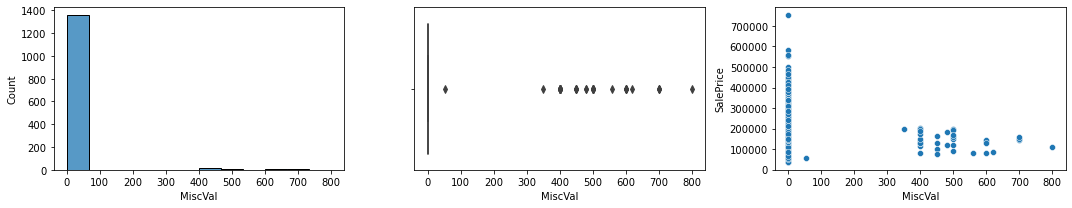

In [42]:
d = d_tr
for col in num_f:
    fig, ax = plt.subplots(1, 3, figsize=(15,3))
    sns.histplot(data=d, x=col, ax=ax[0])
    sns.boxplot(data=d, x=col, ax=ax[1]);
    sns.scatterplot(data=d, x=col, y=y, ax=ax[2]);
    plt.tight_layout() #to fix overlap

In [47]:
with pd.option_context('display.max_columns', None,):
    temp_dum = pd.get_dummies(d_tr)[:7]
    display(temp_dum)
    print('new shape: ',temp_dum.shape)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,OverallQual_1,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_1,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,BsmtFullBath_0.0,BsmtFullBath_1.0,BsmtFullBath_2.0,BsmtHalfBath_0.0,BsmtHalfBath_1.0,BsmtHalfBath_2.0,FullBath_0,FullBath_1,FullBath

new shape:  (7, 376)
